<a href="https://colab.research.google.com/github/MakhovaAnastasia/kursovaya_3/blob/main/lstm_Makhova_3kurs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Махова Анастасия

Прогнозирование финансовых временных рядов с помощью нейронных сетей с памятью

In [ ]:
#импорт библиотек

import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt

import yfinance as yf

from datetime import date
import sklearn.metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy as CCE
from tensorflow.keras import layers
from tensorflow.keras.metrics import Recall
from tensorflow.keras.metrics import Precision

In [ ]:
#
df = yf.download("AAPL", interval = "1m" )

[*********************100%***********************]  1 of 1 completed


In [ ]:
df.reset_index(inplace = True)

In [ ]:
df.head()

,Datetime,Open,High,Low,Close,Adj Close,Volume
0,2023-05-15 09:30:00-04:00,173.160004,173.210007,172.690002,173.000000,173.000000,1534199
1,2023-05-15 09:31:00-04:00,173.000000,173.119995,172.919998,173.029999,173.029999,205263
2,2023-05-15 09:32:00-04:00,173.020004,173.190002,172.979996,173.020004,173.020004,195943
3,2023-05-15 09:33:00-04:00,173.018799,173.179993,172.899994,173.050003,173.050003,200684
4,2023-05-15 09:34:00-04:00,173.057007,173.134995,172.931595,172.949997,172.949997,135284


<function matplotlib.pyplot.show(close=None, block=None)>

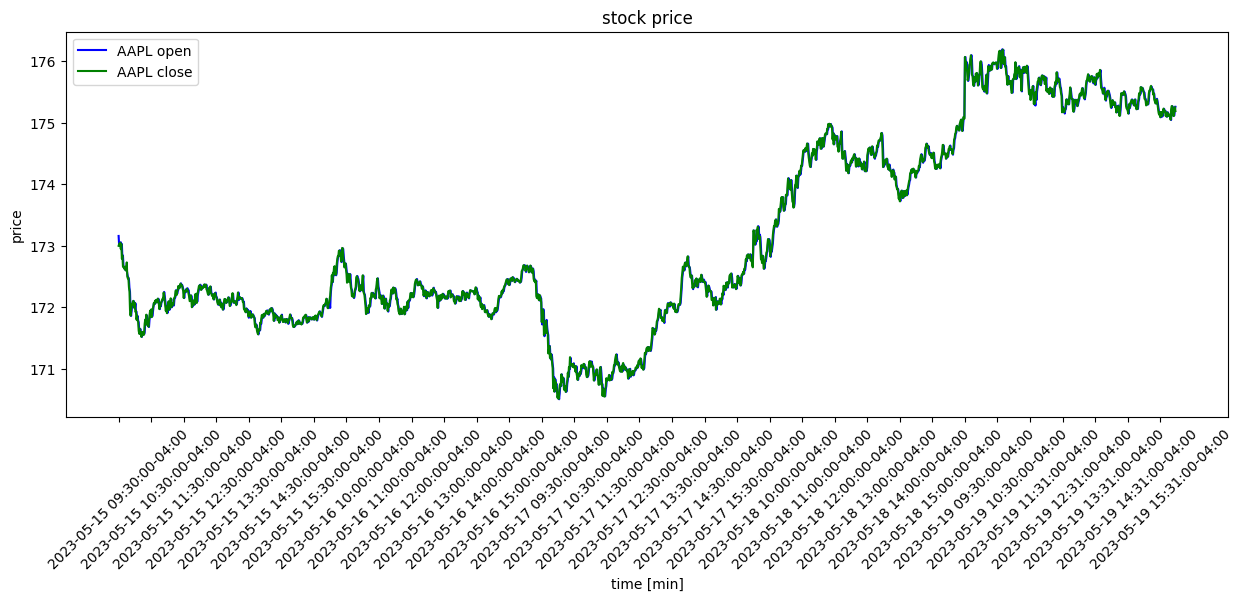

In [ ]:
%matplotlib inline
plt.figure(figsize=(15, 5));

plt.plot(df.index,df.Open.values, color='blue', label='AAPL open')
plt.plot(df.index,df.Close.values, color='green', label='AAPL close')

plt.xticks(range(0,df.shape[0],60),df[::60].Datetime,rotation=45)
plt.title('stock price')
plt.xlabel('time [min]')
plt.ylabel('price')
plt.legend(loc='best')
plt.show

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1949 entries, 0 to 1948
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype                           
---  ------     --------------  -----                           
 0   Datetime   1949 non-null   datetime64[ns, America/New_York]
 1   Open       1949 non-null   float64                         
 2   High       1949 non-null   float64                         
 3   Low        1949 non-null   float64                         
 4   Close      1949 non-null   float64                         
 5   Adj Close  1949 non-null   float64                         
 6   Volume     1949 non-null   int64                           
dtypes: datetime64[ns, America/New_York](1), float64(5), int64(1)
memory usage: 106.7 KB


создадим столбец Тренд(3 вида).

In [ ]:
eps = 0.01 #вводим погрешность, чтобы определить, когда тренд боковой
t = 30 #тик (1 - считаем тренд внутри свечи, в общем случае: тренд(i) = close(i+t) - open(i))
df['Trend'] = (df['Close'].shift(-t+1)-df['Open'])
#       тренд:
#    восходящий =  1
#    боковой    =  0
#    нисходящий = -1
df['Trend'] = np.where(df['Trend'].abs() <eps , 0, np.sign(df['Trend']))
df

,Datetime,Open,High,Low,Close,Adj Close,Volume,Trend
0,2023-05-15 09:30:00-04:00,173.160004,173.210007,172.690002,173.000000,173.000000,1534199,-1.0
1,2023-05-15 09:31:00-04:00,173.000000,173.119995,172.919998,173.029999,173.029999,205263,-1.0
2,2023-05-15 09:32:00-04:00,173.020004,173.190002,172.979996,173.020004,173.020004,195943,-1.0
3,2023-05-15 09:33:00-04:00,173.018799,173.179993,172.899994,173.050003,173.050003,200684,-1.0
4,2023-05-15 09:34:00-04:00,173.057007,173.134995,172.931595,172.949997,172.949997,135284,-1.0
...,...,...,...,...,...,...,...,...
1944,2023-05-19 15:55:00-04:00,175.214996,175.229996,175.100006,175.110001,175.110001,277231,NaN
1945,2023-05-19 15:56:00-04:00,175.115005,175.125000,175.020004,175.110001,175.110001,257685,NaN
1946,2023-05-19 15:57:00-04:00,175.119995,175.250000,175.115005,175.210007,175.210007,439759,NaN
1947,2023-05-19 15:58:00-04:00,175.214996,175.289993,175.210007,175.255005,175.255005,385927,NaN


In [ ]:
df['Trend'].value_counts()

 1.0    1012
-1.0     860
 0.0      48
Name: Trend, dtype: int64

сохраним данные на всякий случай так как в библиотеке поминутные данные

только за 7 последних дней

In [ ]:
#df.to_csv("5.csv")

Создадим новый датафрейм, в который добавим необходимые столбцы - feachures

In [ ]:
df_1 = df.loc[:,["Datetime", "Trend", "Close","Open","High", "Low"]] #
#Обязательно:
#0 - Datetime
#1 - Trend

In [ ]:
# мы не знаем последние t трендов - уберем их
df_1.drop(df_1.tail(t).index,inplace=True)

In [ ]:
df_1

,Datetime,Trend,Close,Open,High,Low
0,2023-05-15 09:30:00-04:00,-1.0,173.000000,173.160004,173.210007,172.690002
1,2023-05-15 09:31:00-04:00,-1.0,173.029999,173.000000,173.119995,172.919998
2,2023-05-15 09:32:00-04:00,-1.0,173.020004,173.020004,173.190002,172.979996
3,2023-05-15 09:33:00-04:00,-1.0,173.050003,173.018799,173.179993,172.899994
4,2023-05-15 09:34:00-04:00,-1.0,172.949997,173.057007,173.134995,172.931595
...,...,...,...,...,...,...
1914,2023-05-19 15:25:00-04:00,-1.0,175.354996,175.389999,175.399994,175.339996
1915,2023-05-19 15:26:00-04:00,-1.0,175.298203,175.354996,175.359100,175.289307
1916,2023-05-19 15:27:00-04:00,-1.0,175.225006,175.289993,175.297897,175.213303
1917,2023-05-19 15:28:00-04:00,-1.0,175.160004,175.225006,175.235001,175.149994


Представим тренд в виде One-Hot Encoder. $[..,..,..]$, где 1 ставится в столбце соответствующего тренда, а оставшиеся пропуски заполняются нулями

In [ ]:
df_2 = pd.get_dummies(df_1["Trend"])
df_2.columns = ['down','neutral', 'up']
df_2

,down,neutral,up
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
1914,1,0,0
1915,1,0,0
1916,1,0,0
1917,1,0,0


In [ ]:
df_1 = pd.merge(df_1,df_2,left_index=True, right_index=True)

Нормализуем данные

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# apply normalization techniques

column = 'Trend'
df_1[column] = MinMaxScaler().fit_transform(np.array(df_1[column]).reshape(-1,1))

column = 'Close'
df_1[column] = MinMaxScaler().fit_transform(np.array(df_1[column]).reshape(-1,1))

column = 'High'
df_1[column] = MinMaxScaler().fit_transform(np.array(df_1[column]).reshape(-1,1))

column = 'Low'
df_1[column] = MinMaxScaler().fit_transform(np.array(df_1[column]).reshape(-1,1))

column = 'Open'
df_1[column] = MinMaxScaler().fit_transform(np.array(df_1[column]).reshape(-1,1))


In [ ]:
df_1

,Datetime,Trend,Close,Open,High,Low,down,neutral,up
0,2023-05-15 09:30:00-04:00,0.0,0.438489,0.466608,0.461948,0.396150,1,0,0
1,2023-05-15 09:31:00-04:00,0.0,0.443772,0.438488,0.446016,0.436290,1,0,0
2,2023-05-15 09:32:00-04:00,0.0,0.442012,0.442003,0.458407,0.446761,1,0,0
3,2023-05-15 09:33:00-04:00,0.0,0.447295,0.441791,0.456635,0.432799,1,0,0
4,2023-05-15 09:34:00-04:00,0.0,0.429683,0.448506,0.448671,0.438314,1,0,0
...,...,...,...,...,...,...,...,...,...
1914,2023-05-19 15:25:00-04:00,0.0,0.853203,0.858522,0.849556,0.858636,1,0,0
1915,2023-05-19 15:26:00-04:00,0.0,0.843202,0.852371,0.842318,0.849790,1,0,0
1916,2023-05-19 15:27:00-04:00,0.0,0.830312,0.840947,0.831486,0.836525,1,0,0
1917,2023-05-19 15:28:00-04:00,0.0,0.818865,0.829525,0.820354,0.825477,1,0,0


In [ ]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1919 entries, 0 to 1918
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype                           
---  ------    --------------  -----                           
 0   Datetime  1919 non-null   datetime64[ns, America/New_York]
 1   Trend     1919 non-null   float64                         
 2   Close     1919 non-null   float64                         
 3   Open      1919 non-null   float64                         
 4   High      1919 non-null   float64                         
 5   Low       1919 non-null   float64                         
 6   down      1919 non-null   uint8                           
 7   neutral   1919 non-null   uint8                           
 8   up        1919 non-null   uint8                           
dtypes: datetime64[ns, America/New_York](1), float64(5), uint8(3)
memory usage: 95.7 KB


Представим датасет в особом виде: (time, window_size, n_feachures)\
time - число наблюдений\
window_size - размер окна. Мы будем двигать окно во времени, чтобы предсказать следующее за ним значение(см. картинку)\
n_feachures - количество столбцов данных, на основе которых будет строиться прогноз

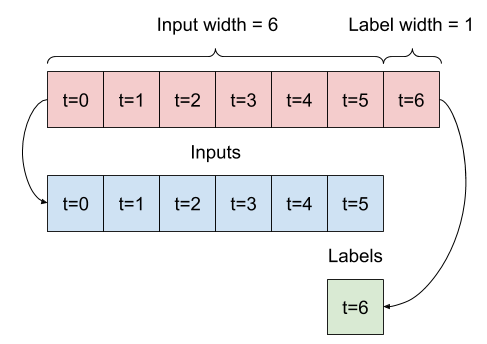

In [ ]:
def df_to_windowed(dataframe, n, n_feachures):

  target_date = n

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    y = np.zeros(3)
    y[0] = df_subset.at[target_date, 'down']
    y[1] = df_subset.at[target_date, 'neutral']
    y[2] = df_subset.at[target_date, 'up']
    dates.append(target_date)
    Y.append(y)
    X.append(df_subset.iloc[:-1,1:-3].values)

    if last_time:
      break

    target_date = target_date + 1

    if target_date == len(dataframe) - 1:
      last_time = True

  X = np.array(X)
  Y = np.array(Y)
  #  Y = np.vstack(Y)
  dates = np.array(dates)

  return dates, X.astype(np.float32), Y.astype(np.float32)

In [ ]:
window_size = 10

In [ ]:
dates, X, y = df_to_windowed(df_1, n=window_size, n_feachures = 5)

dates.shape, X.shape, y.shape

((1909,), (1909, 10, 5), (1909, 3))

разделим данные на тренировочные, валидационные и тестовые в соотношении (80%, 10%, 10%)

In [ ]:
n = len(df)
train_d, train_X, train_y = dates[0:int(n*0.8)], X[0:int(n*0.8)], y[0:int(n*0.8)]
val_d, val_X,val_y = dates[int(n*0.8):int(n*0.9)], X[int(n*0.8):int(n*0.9)], y[int(n*0.8):int(n*0.9)]
test_d, test_X, test_y = dates[int(n*0.9):],X[int(n*0.9):], y[int(n*0.9):]

In [ ]:
units = 3

-----------------
-------------------------

In [ ]:
model1 = Sequential([layers.LSTM(units,input_shape = (train_X.shape[1], train_X.shape[2])),
                    layers.Dense(3,  activation = 'softmax')])

model1.compile(loss='categorical_crossentropy',
              optimizer= Adam(learning_rate = 0.01),
              metrics=['accuracy',Recall(name='recall'),Precision(name='precision')])

m1 = model1.fit(train_X, train_y, validation_data=(val_X, val_y), epochs= 20, shuffle = False)

Epoch 1/20
49/49 [==============================] - 4s 30ms/step - loss: 0.8023 - accuracy: 0.6921 - recall: 0.3708 - precision: 0.8784 - val_loss: 0.6853 - val_accuracy: 0.7487 - val_recall: 0.7282 - val_precision: 0.7676
Epoch 2/20
49/49 [==============================] - 0s 10ms/step - loss: 0.5103 - accuracy: 0.8493 - recall: 0.8364 - precision: 0.8664 - val_loss: 0.5010 - val_accuracy: 0.8205 - val_recall: 0.8103 - val_precision: 0.8187
Epoch 3/20
49/49 [==============================] - 0s 10ms/step - loss: 0.4184 - accuracy: 0.8724 - recall: 0.8685 - precision: 0.8769 - val_loss: 0.4397 - val_accuracy: 0.8462 - val_recall: 0.8410 - val_precision: 0.8586
Epoch 4/20
49/49 [==============================] - 0s 6ms/step - loss: 0.3907 - accuracy: 0.8781 - recall: 0.8717 - precision: 0.8848 - val_loss: 0.4195 - val_accuracy: 0.8564 - val_recall: 0.8513 - val_precision: 0.8783
Epoch 5/20
49/49 [==============================] - 0s 6ms/step - loss: 0.3770 - accuracy: 0.8858 - recall: 0

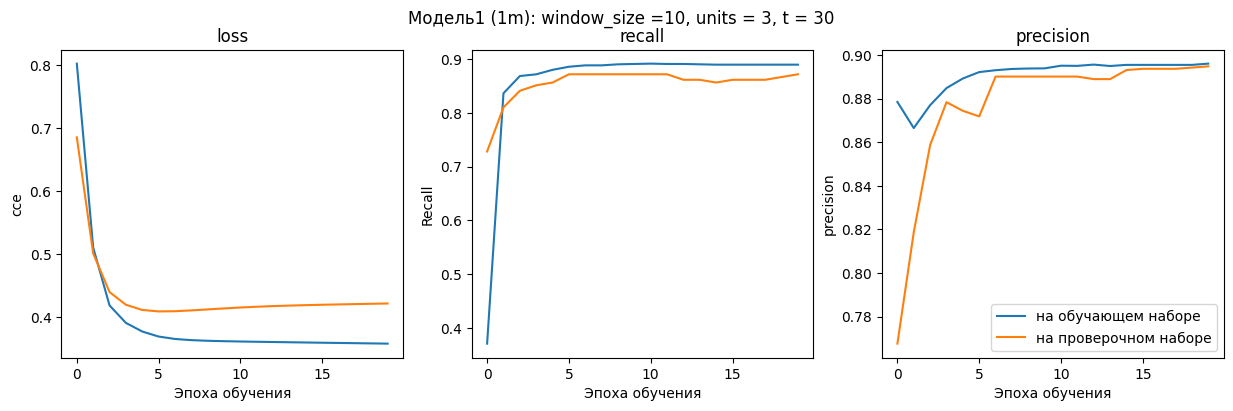

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3,
                                    figsize=(15, 4))

axs[0].set_title('loss')
axs[0].plot(m1.history['loss'],
         label='loss на обучающем наборе')
axs[0].plot(m1.history['val_loss'],
         label='loss на проверочном наборе')
axs[0].set_xlabel('Эпоха обучения')
axs[0].set_ylabel('cce')

axs[1].set_title('recall')
axs[1].plot(m1.history['recall'],
         label='Recall на обучающем наборе')
axs[1].plot(m1.history['val_recall'],
         label='Recall на проверочном наборе')
axs[1].set_xlabel('Эпоха обучения')
axs[1].set_ylabel('Recall')

axs[2].set_title('precision')
axs[2].plot(m1.history['precision'],
         label='на обучающем наборе')
axs[2].plot(m1.history['val_precision'],
         label='на проверочном наборе')
axs[2].set_xlabel('Эпоха обучения')
axs[2].set_ylabel('precision')

axs[2].legend()

fig.suptitle(f'Модель1 (1m): window_size ={window_size}, units = {units}, t = {t} ')
fig.savefig(f'm1_{window_size}_{units}_{t}.png')
plt.show()

Предскажем тренд для тестового множества

In [ ]:
predictions = model1.predict(test_X)


5/5 [==============================] - 0s 3ms/step


In [ ]:
# для наглядности рассмотрим 1 прогноз:
# у нас предсказан вектор с вероятностями ответов.
# выбираем наиболее вероятный
labels = ['down', 'neutral', 'up']
print(predictions[1], labels[np.argmax(predictions[1])])

[0.03033922 0.01291021 0.9567505 ] up


In [ ]:
pred= predictions.argmax(axis = 1) - 1
pred

#-1|0|1  ответ
# 0|1|2  индексы
#поэтому сдвигаем на -1, чтобы из индекса получить ответ


array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1,  1,  1,  1,  1, -1,  1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1])

In [ ]:
df_res = pd.DataFrame(data={'Predictions': pred,
                          'Actuals':test_y.argmax(axis = 1) - 1,
                        })

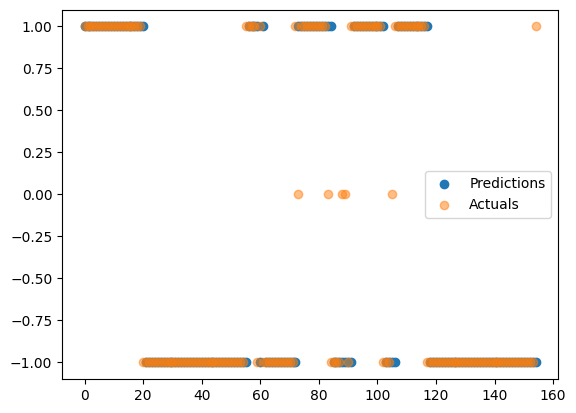

In [ ]:
plt.scatter(df_res.index, df_res["Predictions"], label = 'Predictions')
plt.scatter(df_res.index, df_res["Actuals"], alpha = 0.5,label = 'Actuals')
plt.legend()
plt.show()

In [ ]:
df_res['='] = np.where(df_res['Actuals'] == df_res['Predictions'], 'Yes','No')
df_res

,Predictions,Actuals,=
0,1,1,Yes
1,1,1,Yes
2,1,1,Yes
3,1,1,Yes
4,1,1,Yes
...,...,...,...
150,-1,-1,Yes
151,-1,-1,Yes
152,-1,-1,Yes
153,-1,-1,Yes


In [ ]:
# найдем число верных ответов
df_res['='].value_counts()

Yes    138
No      17
Name: =, dtype: int64

-----------------------------
--------------------------

In [ ]:
model2 = Sequential([layers.LSTM(units,input_shape = (train_X.shape[1], train_X.shape[2])),
                    layers.Activation('softmax')])

model2.compile(loss='categorical_crossentropy',
              optimizer= Adam(learning_rate = 0.01),
              metrics=[Recall(name='recall'),Precision(name='precision')])

m2 = model2.fit(train_X, train_y, validation_data=(val_X, val_y), epochs= 20, shuffle = False)


Epoch 1/20
49/49 [==============================] - 7s 31ms/step - loss: 0.8189 - recall: 0.3829 - precision: 0.8665 - val_loss: 0.8036 - val_recall: 0.6615 - val_precision: 0.6754
Epoch 2/20
49/49 [==============================] - 0s 6ms/step - loss: 0.6272 - recall: 0.7716 - precision: 0.8331 - val_loss: 0.7011 - val_recall: 0.7282 - val_precision: 0.7435
Epoch 3/20
49/49 [==============================] - 0s 7ms/step - loss: 0.5583 - recall: 0.8178 - precision: 0.8551 - val_loss: 0.6293 - val_recall: 0.7692 - val_precision: 0.7895
Epoch 4/20
49/49 [==============================] - 0s 7ms/step - loss: 0.5278 - recall: 0.8364 - precision: 0.8705 - val_loss: 0.5947 - val_recall: 0.7949 - val_precision: 0.8115
Epoch 5/20
49/49 [==============================] - 0s 7ms/step - loss: 0.5139 - recall: 0.8422 - precision: 0.8753 - val_loss: 0.5933 - val_recall: 0.7846 - val_precision: 0.8095
Epoch 6/20
49/49 [==============================] - 0s 7ms/step - loss: 0.5108 - recall: 0.8473 - p

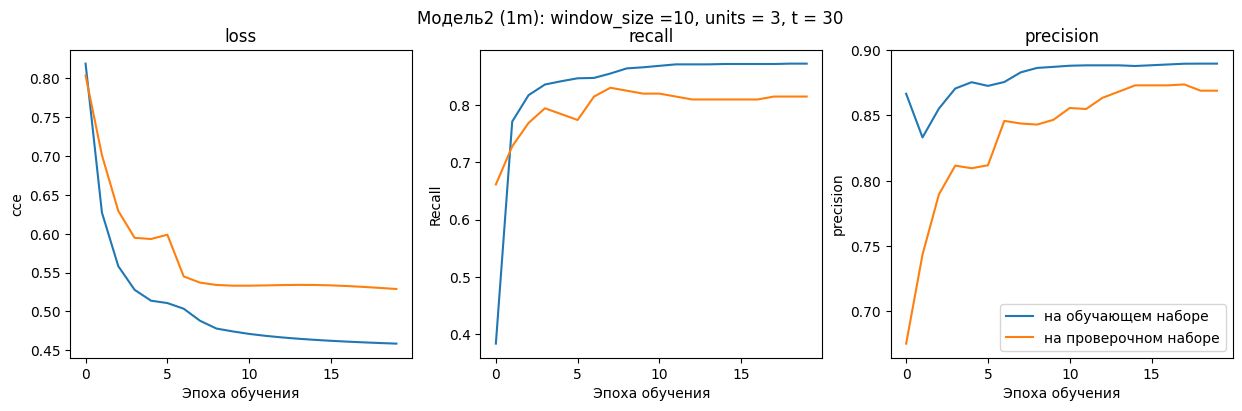

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3,
                                    figsize=(15, 4))

axs[0].set_title('loss')
axs[0].plot(m2.history['loss'],
         label='loss на обучающем наборе')
axs[0].plot(m2.history['val_loss'],
         label='loss на проверочном наборе')
axs[0].set_xlabel('Эпоха обучения')
axs[0].set_ylabel('cce')

axs[1].set_title('recall')
axs[1].plot(m2.history['recall'],
         label='Recall на обучающем наборе')
axs[1].plot(m2.history['val_recall'],
         label='Recall на проверочном наборе')
axs[1].set_xlabel('Эпоха обучения')
axs[1].set_ylabel('Recall')

axs[2].set_title('precision')
axs[2].plot(m2.history['precision'],
         label='на обучающем наборе')
axs[2].plot(m2.history['val_precision'],
         label='на проверочном наборе')
axs[2].set_xlabel('Эпоха обучения')
axs[2].set_ylabel('precision')

axs[2].legend()

fig.suptitle(f'Модель2 (1m): window_size ={window_size}, units = {units}, t = {t} ')
fig.savefig(f'm2_{window_size}_{units}_{t}.png')
plt.show()

--------------------------
--------------------------

In [ ]:
model3 = Sequential([layers.Input((train_X.shape[1], train_X.shape[2])),
                    layers.LSTM(9,input_shape = (train_X.shape[1], train_X.shape[2]), return_sequences= True),
                    layers.BatchNormalization(),
                    layers.LSTM(3),
                    layers.Dense(3, activation = 'softmax')])

model3.compile(loss='categorical_crossentropy',
              optimizer= Adam(learning_rate = 0.01),
              metrics=['accuracy',Recall(name='recall'),Precision(name='precision')])

m3 = model3.fit(train_X, train_y, validation_data=(val_X, val_y), epochs= 20, shuffle = False)

Epoch 1/20
49/49 [==============================] - 13s 35ms/step - loss: 0.6051 - accuracy: 0.8223 - recall: 0.7569 - precision: 0.8339 - val_loss: 0.6834 - val_accuracy: 0.7590 - val_recall: 0.6923 - val_precision: 0.7803
Epoch 2/20
49/49 [==============================] - 1s 12ms/step - loss: 0.4459 - accuracy: 0.8608 - recall: 0.8557 - precision: 0.8668 - val_loss: 0.5055 - val_accuracy: 0.8410 - val_recall: 0.8410 - val_precision: 0.8410
Epoch 3/20
49/49 [==============================] - 1s 13ms/step - loss: 0.4038 - accuracy: 0.8781 - recall: 0.8743 - precision: 0.8799 - val_loss: 0.4421 - val_accuracy: 0.8462 - val_recall: 0.8462 - val_precision: 0.8462
Epoch 4/20
49/49 [==============================] - 1s 13ms/step - loss: 0.3832 - accuracy: 0.8877 - recall: 0.8820 - precision: 0.8900 - val_loss: 0.4879 - val_accuracy: 0.8308 - val_recall: 0.8256 - val_precision: 0.8342
Epoch 5/20
49/49 [==============================] - 1s 12ms/step - loss: 0.3856 - accuracy: 0.8865 - recall

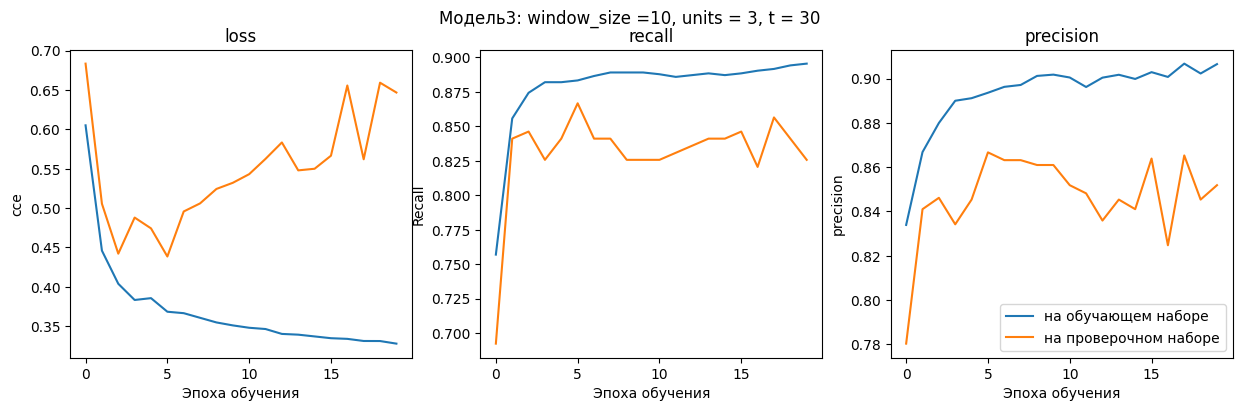

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3,
                                    figsize=(15, 4))

axs[0].set_title('loss')
axs[0].plot(m3.history['loss'],
         label='loss на обучающем наборе')
axs[0].plot(m3.history['val_loss'],
         label='loss на проверочном наборе')
axs[0].set_xlabel('Эпоха обучения')
axs[0].set_ylabel('cce')

axs[1].set_title('recall')
axs[1].plot(m3.history['recall'],
         label='Recall на обучающем наборе')
axs[1].plot(m3.history['val_recall'],
         label='Recall на проверочном наборе')
axs[1].set_xlabel('Эпоха обучения')
axs[1].set_ylabel('Recall')

axs[2].set_title('precision')
axs[2].plot(m3.history['precision'],
         label='на обучающем наборе')
axs[2].plot(m3.history['val_precision'],
         label='на проверочном наборе')
axs[2].set_xlabel('Эпоха обучения')
axs[2].set_ylabel('precision')

axs[2].legend()

fig.suptitle(f'Модель3: window_size ={window_size}, units = {units}, t = {t} ')
fig.savefig(f'm3_{window_size}_{units}_{t}.png')
plt.show()

-----------------------------
-----------------------------
СРАВНЕНИЕ  ARIMA и LSTM

ARIMA

Тренд для 2х классов

In [ ]:
t = 30 #тик (1 - считаем тренд внутри свечи, в общем случае: тренд(i) = close(i+t) - open(i))
df['Trend'] = (df['Close'].shift(-t+1)-df['Open'])
#       тренд:
#    восходящий =  1
#    нисходящий = 0
df['Trend'] = np.where(df['Trend'] <0 , 0, 1)
df

,Datetime,Open,High,Low,Close,Adj Close,Volume,Trend
0,2023-05-15 09:30:00-04:00,173.160004,173.210007,172.690002,173.000000,173.000000,1534199,0
1,2023-05-15 09:31:00-04:00,173.000000,173.119995,172.919998,173.029999,173.029999,205263,0
2,2023-05-15 09:32:00-04:00,173.020004,173.190002,172.979996,173.020004,173.020004,195943,0
3,2023-05-15 09:33:00-04:00,173.018799,173.179993,172.899994,173.050003,173.050003,200684,0
4,2023-05-15 09:34:00-04:00,173.057007,173.134995,172.931595,172.949997,172.949997,135284,0
...,...,...,...,...,...,...,...,...
1944,2023-05-19 15:55:00-04:00,175.214996,175.229996,175.100006,175.110001,175.110001,277231,1
1945,2023-05-19 15:56:00-04:00,175.115005,175.125000,175.020004,175.110001,175.110001,257685,1
1946,2023-05-19 15:57:00-04:00,175.119995,175.250000,175.115005,175.210007,175.210007,439759,1
1947,2023-05-19 15:58:00-04:00,175.214996,175.289993,175.210007,175.255005,175.255005,385927,1


In [ ]:
import statsmodels.api as sm

In [ ]:
df_0 = df.loc[:,"Trend"]
# мы не знаем последние t трендов - уберем их
df_0.drop(df_0.tail(t).index,inplace=True)

In [ ]:
#тест на стационарность

test = sm.tsa.adfuller(df_0)
print( 'adf: ', test[0] )
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']:
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -8.547316516294487
p-value:  9.42640934143089e-14
Critical values:  {'1%': -3.4337693666817204, '5%': -2.8630504552921123, '10%': -2.5675741080108256}
единичных корней нет, ряд стационарен


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


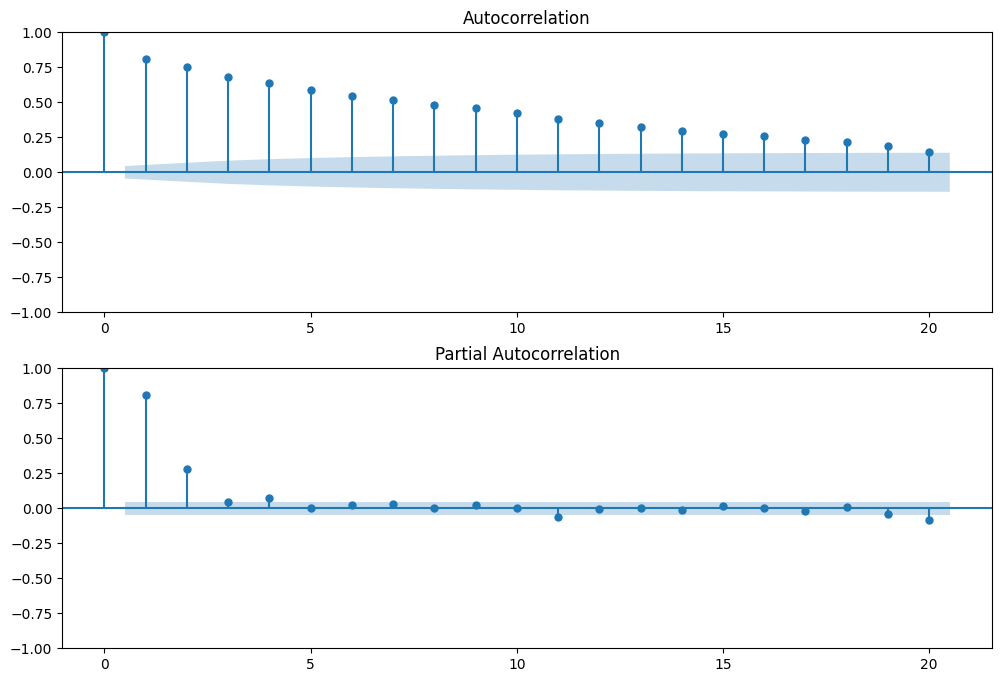

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_0.values.squeeze(), lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_0, lags=20, ax=ax2)

In [ ]:
n = len(df_0)
train, val, test = df_0[0:int(n*0.8)], df_0[int(n*0.8):int(n*0.9)], df_0[int(n*0.9):]

In [ ]:
from scipy.special import expit, logit
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, accuracy_score

In [ ]:
all_res = {}
best_model = None
best_aic, best_order = np.inf, 0

for p in range(0,2):
    for q in range(0,18):

        mod = sm.tsa.statespace.SARIMAX(logit(train.clip(1e-3, 1 - 1e-3)),
                                      order=(p, 0, q),enforce_invertibility=False,
                                      simple_differencing = False, enforce_stationarity= False)
        try:
            res = mod.fit(disp=False)
            all_res[(p,q)] = res.aic
        except:
            all_res[(p,q)] = np.inf

        if all_res[(p,q)] < best_aic:
            best_aic = all_res[(p,q)]
            best_order = (p,q)
            best_model = res
print('BEST ORDER', best_order, 'BEST AIC:', best_aic)

BEST ORDER (1, 17) BEST AIC: 8410.526088903971


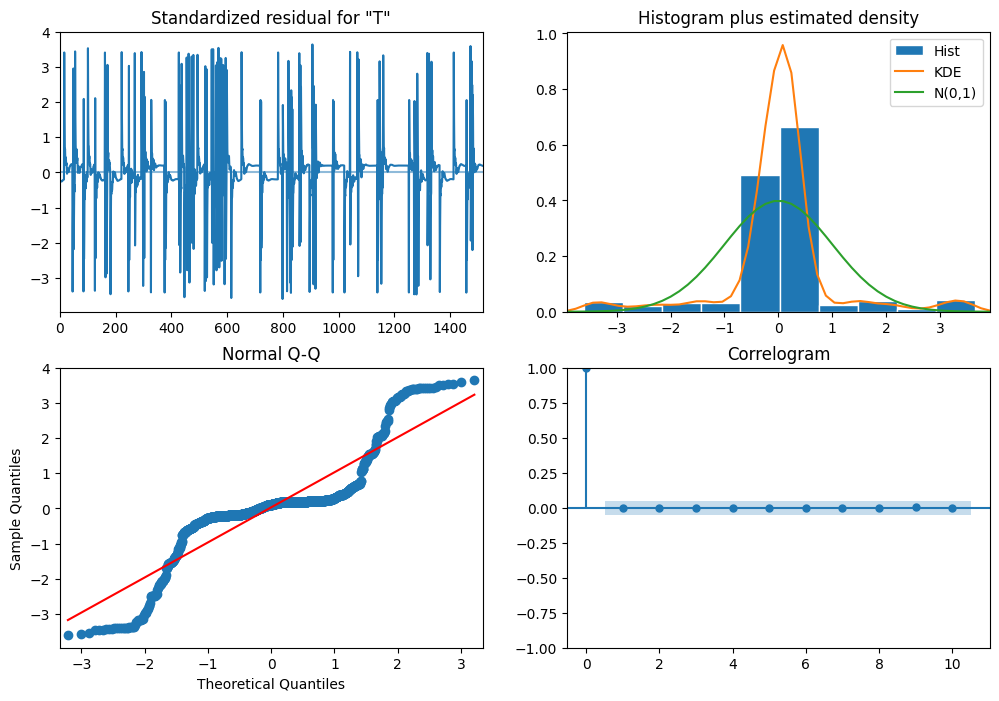

In [ ]:
best_model.plot_diagnostics(figsize=(12,8))
plt.show()


In [ ]:
pred = best_model.get_prediction(end=res.nobs +len(val))

In [ ]:
pr = expit(pred.predicted_mean)
pr =  np.where(pr > (1-pr) , 1, 0) #если вероятность "1-восходящий" больше вероятности "0-нисходящий", то ответ 1, иначе 0
ans = pr[-len(val):]

In [ ]:
accuracy = accuracy_score(val, ans)
precision = precision_score(val, ans)
recall = recall_score(val, ans)
print( 'accuracy: ', accuracy )
print( 'precision: ', precision )
print( 'recall: ', recall )

accuracy:  0.4635416666666667
precision:  0.4635416666666667
recall:  1.0


LSTM

In [ ]:
df_1 = df.loc[:,["Datetime", "Trend"]] #, "Close","Open","High", "Low"
#Обязательно:
#0 - Datetime
#1 - Trend

In [ ]:
# мы не знаем последние t трендов - уберем их
df_1.drop(df_1.tail(t).index,inplace=True)

In [ ]:
df_1

,Datetime,Trend
0,2023-05-15 09:30:00-04:00,0
1,2023-05-15 09:31:00-04:00,0
2,2023-05-15 09:32:00-04:00,0
3,2023-05-15 09:33:00-04:00,0
4,2023-05-15 09:34:00-04:00,0
...,...,...
1914,2023-05-19 15:25:00-04:00,0
1915,2023-05-19 15:26:00-04:00,0
1916,2023-05-19 15:27:00-04:00,0
1917,2023-05-19 15:28:00-04:00,0


In [ ]:
window_size = 10

In [ ]:
def df_to_windowed_2(dataframe, n, n_feachures):

  target_date = n

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    y = np.zeros(1)
    y[0] = df_subset.at[target_date, 'Trend']
    dates.append(target_date)
    Y.append(y)
    X.append(df_subset.iloc[:-1,1:].values)

    if last_time:
      break

    target_date = target_date + 1

    if target_date == len(dataframe) - 1:
      last_time = True

  X = np.array(X)
  Y = np.array(Y)
  #  Y = np.vstack(Y)
  dates = np.array(dates)

  return dates, X.astype(np.float32), Y.astype(np.float32)

In [ ]:
dates, X, y = df_to_windowed_2(df_1, n=window_size, n_feachures = 5)

dates.shape, X.shape, y.shape

((1909,), (1909, 10, 1), (1909, 1))

In [ ]:
n = len(df)
train_d, train_X, train_y = dates[0:int(n*0.8)], X[0:int(n*0.8)], y[0:int(n*0.8)]
val_d, val_X,val_y = dates[int(n*0.8):int(n*0.9)], X[int(n*0.8):int(n*0.9)], y[int(n*0.8):int(n*0.9)]
test_d, test_X, test_y = dates[int(n*0.9):],X[int(n*0.9):], y[int(n*0.9):]

In [ ]:
model1 = Sequential([layers.LSTM(1,input_shape = (train_X.shape[1], train_X.shape[2])),
                    layers.Activation('sigmoid')])

model1.compile(loss='binary_crossentropy',
              optimizer= Adam(learning_rate = 0.01),
              metrics=['accuracy',Recall(name='recall'),Precision(name='precision')])

m1 = model1.fit(train_X, train_y, validation_data=(val_X, val_y), epochs= 20, shuffle = False)

Epoch 1/20
49/49 [==============================] - 4s 19ms/step - loss: 0.6073 - accuracy: 0.8089 - recall: 0.9586 - precision: 0.7665 - val_loss: 0.5863 - val_accuracy: 0.7846 - val_recall: 0.8068 - val_precision: 0.7396
Epoch 2/20
49/49 [==============================] - 0s 7ms/step - loss: 0.5405 - accuracy: 0.8384 - recall: 0.9049 - precision: 0.8289 - val_loss: 0.5503 - val_accuracy: 0.7949 - val_recall: 0.7500 - val_precision: 0.7857
Epoch 3/20
49/49 [==============================] - 0s 6ms/step - loss: 0.5033 - accuracy: 0.8525 - recall: 0.9004 - precision: 0.8510 - val_loss: 0.5207 - val_accuracy: 0.8308 - val_recall: 0.7955 - val_precision: 0.8235
Epoch 4/20
49/49 [==============================] - 0s 6ms/step - loss: 0.4763 - accuracy: 0.8691 - recall: 0.9094 - precision: 0.8686 - val_loss: 0.5002 - val_accuracy: 0.8410 - val_recall: 0.7955 - val_precision: 0.8434
Epoch 5/20
49/49 [==============================] - 0s 6ms/step - loss: 0.4597 - accuracy: 0.8743 - recall: 0.9

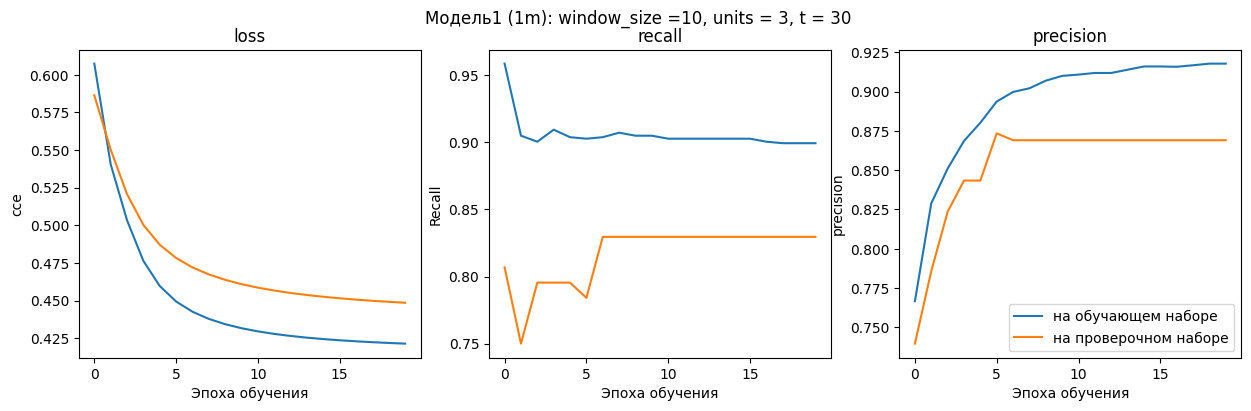

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3,
                                    figsize=(15, 4))

axs[0].set_title('loss')
axs[0].plot(m1.history['loss'],
         label='loss на обучающем наборе')
axs[0].plot(m1.history['val_loss'],
         label='loss на проверочном наборе')
axs[0].set_xlabel('Эпоха обучения')
axs[0].set_ylabel('cce')

axs[1].set_title('recall')
axs[1].plot(m1.history['recall'],
         label='Recall на обучающем наборе')
axs[1].plot(m1.history['val_recall'],
         label='Recall на проверочном наборе')
axs[1].set_xlabel('Эпоха обучения')
axs[1].set_ylabel('Recall')

axs[2].set_title('precision')
axs[2].plot(m1.history['precision'],
         label='на обучающем наборе')
axs[2].plot(m1.history['val_precision'],
         label='на проверочном наборе')
axs[2].set_xlabel('Эпоха обучения')
axs[2].set_ylabel('precision')

axs[2].legend()

fig.suptitle(f'Модель1 (1m): window_size ={window_size}, units = {units}, t = {t} ')
fig.savefig(f'm1m_{window_size}_{units}_{t}.png')
plt.show()

In [ ]:
best_accuracy = max(m1.history['accuracy'])
best_precision = max(m1.history['precision'])
best_recall = max(m1.history['recall'])
print( 'accuracy: ', best_accuracy )
print( 'precision: ', best_precision )
print( 'recall: ', best_recall )

accuracy:  0.8967286944389343
precision:  0.9178082346916199
recall:  0.9586129784584045
